In [1]:
from fastplotlib import Plot
import numpy as np

### Simple image

RFBOutputContext()


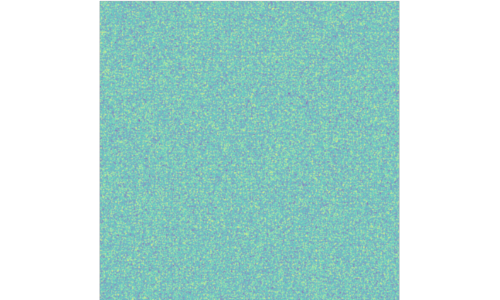

JupyterWgpuCanvas()

In [2]:
plot = Plot()

data = (np.random.rand(512, 512) * 255).astype(np.float32)
plot.image(data=data,  vmin=0, vmax=255, cmap='viridis')

plot.show()

### Update image (video)

RFBOutputContext()


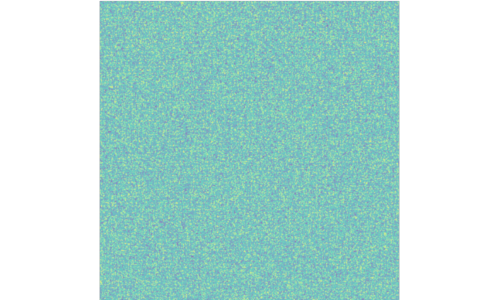

JupyterWgpuCanvas()

In [3]:
plot = Plot()

data = (np.random.rand(512, 512) * 255).astype(np.float32)
image = plot.image(data=data,  vmin=0, vmax=255, cmap='viridis')

def update_data():
    new_data = (np.random.rand(512, 512) * 255).astype(np.float32)
    image.update_data(new_data)

plot.add_animations([update_data])

plot.show()

### 2D line plot

RFBOutputContext()


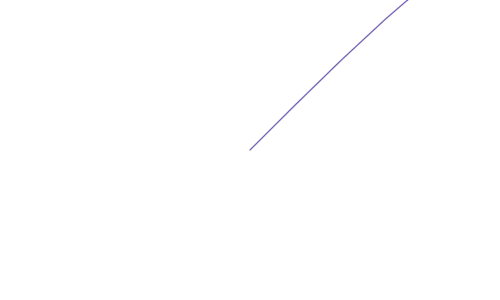

JupyterWgpuCanvas()

In [4]:
plot = Plot()

xs = np.linspace(0, 30, 200)
ys = np.sin(xs)
zs = np.zeros(xs.size)

data = np.dstack([xs, ys, zs])[0]

plot.line(data=data, size=1.5, cmap='plasma')

# zoom out and pan to see the sine wave
plot.show()

### 3D line plot

RFBOutputContext()


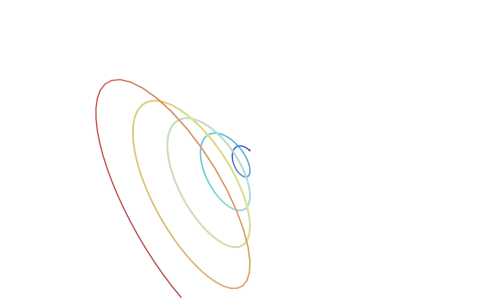

JupyterWgpuCanvas()

In [5]:
plot = Plot(camera='3d')

phi = np.linspace(0, 30, 200)

xs = phi * np.cos(phi)
ys = phi * np.sin(phi)
zs = phi

# data must be 3d, with shape [<n_vertices>, 3]
spiral = np.dstack([xs, ys, zs])[0]

plot.line(data=spiral, size=1.5, cmap='jet')

plot.show()